
#MVP: *Machine Learning & Analytics*
**Autor:** Murillo Barbosa de Andrade  

**Matrícula:** 4052025000833

**Dataset:** [Basketball Players Stats per Season - 49 Leagues](https://www.kaggle.com/datasets/jacobbaruch/basketball-players-stats-per-season-49-leagues)

---



# Glossário e observações

- ***Cestas*** = Em inglês, Field Goals. Se tratam de todos os arremessos convertidos durante o jogo. Ao converter uma cesta antes da linha de 3 pontos, que é mais difícil, o arremesso converte 3 pontos para a equipe.
Quando não for especificado que são cestas de 3 pontos, o atributo se refere à todas as cestas no geral, excluindo lances livres.
- ***Lances livres*** = Em inglês, Free Throws. O jogador que sofrer uma falta enquanto ataca tem a oportunidade de fazer arremessos que valem 1 ponto cada de uma posição próxima à cesta, sem marcação adversária.
- ***Ligas*** = O mesmo jogador pode jogar diferentes ligas. Isso geralmente ocorre quando há ligas continentais: por exemplo, o jogador Yurii Kondrakov jogou em 2019 a Liga Ucraniana e também a FIBA Europe Cup.
- ***Limitações*** = o dataset não possui distinção de posição dos jogadores. Além disso, a qualidade defensiva dos times adversários não é levada em consideração.
- ***Temporada Regular e Mata-Mata:*** O dataset divide a temporada da NBA em temporada regular, em que os times de cada conferência (Leste e Oeste) competem para ficar no top 8 times com mais pontos, para classificarem para a temporada de mata-mata, onde os melhores times se enfrentam em jogos eliminiatórios até sobrar o campeão. O dataset discrimina os dois tipos de temporada, mas agrupei no data frame de forma que só tenha uma linha por jogador da NBA, somando as métricas caso os jogadores tenham jogado até o mata-mata.


## 1. Escopo, objetivo e definição do problema
- **Contexto do problema e objetivo**: A NBA é conhecida como a liga de basquete mais competitiva do mundo, reunindo atletas com habilidades excepcionais e grande visibilidade internacional. No entanto, existem diversas outras ligas espalhadas pelo mundo, cada uma com características próprias que influenciam o estilo de jogo dos atletas, como ritmo, intensidade defensiva, volume de arremessos de três pontos ou dependência de jogadas coletivas. Essas particularidades fazem com que o desempenho de um jogador varie conforme o ambiente competitivo em que atua. O objetivo deste trabalho é aplicar técnicas de machine learning para identificar padrões de desempenho em diferentes ligas, analisando quais estatísticas se destacam em cada contexto e permitindo comparações mais objetivas entre elas. Além disso, busca-se compreender quais ligas, fora da NBA, oferecem métricas ofensivas mais promissoras e quais fatores podem ser decisivos para a identificação de talentos.
- **Tipo de tarefa**: O presente trabalho trata de um problema de classificação supervisionada, pois pretende-se utilizar variáveis numéricas para treinar modelos capazes de distinguir e caracterizar ligas de acordo com o desempenho ofensivo dos jogadores. A ideia é que, a partir das estatísticas históricas, o modelo aprenda a reconhecer padrões e, assim, consiga classificar corretamente um jogador em uma determinada liga. Essa abordagem permite uma análise estruturada, transformando dados brutos em informações úteis para comparações entre contextos competitivos.  
- **Área de aplicação**: O projeto está inserido na área de dados tabulares, já que o dataset utilizado apresenta registros organizados em formato de tabela.
- **Valor para o negócio/usuário**: A análise proposta traz valor para equipes e olheiros entenderem padrões estatísticos de jogadores em diferentes ligas pode ajudar na identificação de talentos emergentes, mesmo em competições com menor visibilidade internacional. Ao oferecer métricas comparáveis, cria-se uma ferramenta de suporte para tomada de decisão em contratações, desenvolvimento de atletas e até no estudo do impacto de diferentes contextos competitivos sobre o rendimento individual. Assim, o valor gerado vai além da simples comparação, abrindo espaço para análises estratégicas e descobertas relevantes para o basquete global.


## 2. Reprodutibilidade e ambiente

In [25]:
# === Setup básico e reprodutibilidade ===
import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             silhouette_score, classification_report, ConfusionMatrixDisplay)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier #import KNN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Para frameworks que suportam seed adicional (ex.: PyTorch/TensorFlow), documente aqui:
# import torch; torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
# import tensorflow as tf; tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


### 2.2 Funções python


In [2]:
def evaluate_classification(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    #vou alterar o AUC para multiclass, utilizando weighted para melhor performance de average
    auc = roc_auc_score(y_true, proba, multi_class="ovr", average="weighted")
    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc}


## 3. Dados: carga, entendimento e qualidade

Link do Dataset: https://www.kaggle.com/datasets/jacobbaruch/basketball-players-stats-per-season-49-leagues

Se trata de um dataset com diversas estatísticas de vários jogadores de basquete no mundo ao longo dos anos. Vou pegar apenas os resultados da última temporada disponível, 2019 - 2020.

In [52]:
#URL de importação do dataset
url = "https://raw.githubusercontent.com/murilloandrade22/MVP_Machine_Learning_20250_01/refs/heads/main/players_stats_by_season_full_details.csv"

# Lê o arquivo utilizando as colunas informadas
dataset = pd.read_csv(url, skiprows=1, delimiter=',')

#quero analisar apenas a temporada mais recente, então vou colocar esse filtro
dataset_2019 = dataset[dataset.iloc[:, 1] == '2019 - 2020']

dataset_2019.head()

,NBA,1999 - 2000,Regular_Season,Shaquille O'Neal,LAL,79,3163.0,956,1665,0,...,"Mar 6, 1972",7-1,216,325,147,United States,Robert G. Cole High School,1.1,1.2,Orlando Magic
46684,Argentinian-Liga-A,2019 - 2020,International,Kelsey Barlow,HISP,27,789.4,179,414,68,...,"Feb 14, 1991",6-5,196.0,200.0,91.0,United States,Cathedral High School,NaN,NaN,NaN
46685,Argentinian-Liga-A,2019 - 2020,International,Anthony Young,FOR,25,806.6,160,329,51,...,"Dec 10, 1989",6-7,201.0,255.0,116.0,United States,Arsenal Technical High School,NaN,NaN,NaN
46686,Argentinian-Liga-A,2019 - 2020,International,Pedro Barral,CAOS,25,759.8,153,331,33,...,"Oct 20, 1994",6-1,185.0,175.0,79.0,Argentina,NaN,NaN,NaN,NaN
46687,Argentinian-Liga-A,2019 - 2020,International,Federico Mariani,ARG,24,856.3,120,277,44,...,"Apr 14, 1992",6-3,191.0,NaN,NaN,Argentina,NaN,NaN,NaN,NaN
46688,Argentinian-Liga-A,2019 - 2020,International,Caio De Souza Pacheco,WBE,21,582.7,134,296,30,...,"Feb 22, 1999",6-2,188.0,190.0,86.0,Brazil,NaN,NaN,NaN,NaN


Atributos do Dataset escolhidos:

*   **liga** (Liga em que o jogador atuou (NBA, Eurocup, etc))
*   **min** (Minutos jogados ao longo da temporada)
*   **cestas_convert** (Número de de Cestas de campo (excluindo lances livres) convertidas)
*   **cestas_tent** (Número de tentativas de Cestas de campo (excluindo lances livres))
*   **3pt_convert** (Número de cestas de 3 pontos convertidas)
*   **3pt_tentativa** (Número de tentativas de cestas de 3 pontos)
*   **lan_livres_convert** (Número de lances livres convertidos)
*   **lan_livres_tent** (Número de tentativas de lances livres)
*   **pts** (Número total de pontos feito pelo jogador)

In [4]:
#filtrando apenas as colunas que vou utilizar
df_inicial = dataset_2019.iloc[:, [0, 3, 6, 7, 8, 9, 10, 11, 12, 21]]

#colocando nomes para as colunas
colunas = ['liga', 'jog', 'min', 'cestas_convert', 'cestas_tent', '3pt_convert','3pt_tentativa','lan_livres_convert','lan_livres_tent', 'pts']

df_inicial.columns = colunas

#com o filtro da temporada, o index precisa ser resetado para voltar ao início, a primeira linha estava como 46684
df_reset = df_inicial.reset_index(drop=True)

df_reset.head()

,liga,jog,min,cestas_convert,cestas_tent,3pt_convert,3pt_tentativa,lan_livres_convert,lan_livres_tent,pts
0,Argentinian-Liga-A,Kelsey Barlow,789.4,179,414,68,203,81,98,507
1,Argentinian-Liga-A,Anthony Young,806.6,160,329,51,125,92,108,463
2,Argentinian-Liga-A,Pedro Barral,759.8,153,331,33,93,102,131,441
3,Argentinian-Liga-A,Federico Mariani,856.3,120,277,44,112,135,151,419
4,Argentinian-Liga-A,Caio De Souza Pacheco,582.7,134,296,30,104,110,145,408


In [5]:
# === Verificações iniciais ===
display(df_reset.sample(5))
print("\nFormato:", df_reset.shape)
print("\nTipos:")
print(df_reset.dtypes)
print("\nValores ausentes por coluna:")
print(df_reset.isna().sum())


,liga,jog,min,cestas_convert,cestas_tent,3pt_convert,3pt_tentativa,lan_livres_convert,lan_livres_tent,pts
1414,Chinese-CBA,YanXi Zhu,1165.0,132,318,107,267,14,19,385
6459,South-Korean-KBL,Chan-Hee Park,626.0,51,164,16,64,17,28,135
5960,Romanian-Divizia-A,Amaury Gorgemans,288.5,40,84,0,3,25,35,105
4075,Italian-Lega-Basket-Serie-A,Lorenzo Bucarelli,70.0,3,9,0,1,4,4,10
2457,Euroleague,Andrew Albicy,580.7,58,157,37,105,25,44,178



Formato: (7264, 10)

Tipos:
liga                   object
jog                    object
min                   float64
cestas_convert          int64
cestas_tent             int64
3pt_convert             int64
3pt_tentativa           int64
lan_livres_convert      int64
lan_livres_tent         int64
pts                     int64
dtype: object

Valores ausentes por coluna:
liga                  0
jog                   0
min                   0
cestas_convert        0
cestas_tent           0
3pt_convert           0
3pt_tentativa         0
lan_livres_convert    0
lan_livres_tent       0
pts                   0
dtype: int64



### 3.1 Análise exploratória resumida (EDA)


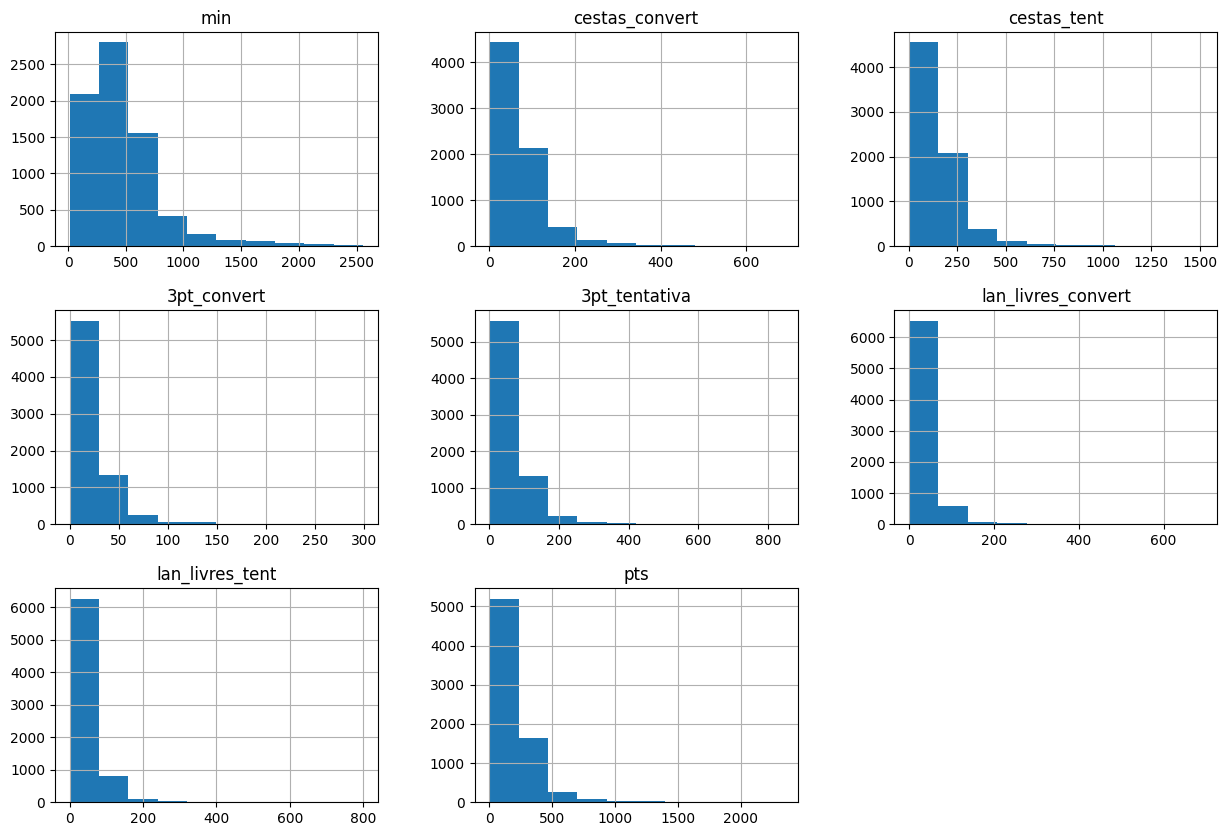

In [6]:
# Histograma numérico
df_reset.hist(figsize = (15,10))
plt.show()

Analisando os gráficos, as variáveis possuem assimetria para a direita, por conta do alto número de jogadores concentrados com menores números. Essa concentração seguida por caudas longas traz a necessidade de normalizar ou padronizar as variáveis para reduzir o impacto de outliers e tornar as escalas comparáveis.

In [7]:
# Contagem de todas as ligas
ligas_count = df_reset["liga"].value_counts()

print(ligas_count)

liga
NBA                                   420
Chinese-CBA                           297
FIBA-Europe-Cup                       242
Japanese-BLeague                      238
Euroleague                            237
Mexican-LNBP                          231
Eurocup                               229
Spanish-ACB                           224
Argentinian-Liga-A                    208
Australian-NBL                        196
German-BBL                            196
French-Jeep-Elite                     188
Turkish-BSL                           185
Brazilian-NBB                         175
Italian-Lega-Basket-Serie-A           170
Polish-TBL                            166
Estonian-Latvian-Basketball-League    164
Romanian-Divizia-A                    161
Serbian-KLS                           156
Greek-HEBA-A1                         155
Finnish-Korisliiga                    148
South-Korean-KBL                      147
Israeli-BSL                           146
Hungarian-NBIA               

No conjunto de dados utilizado, existe um desbalanceamento entre as ligas de basquete. Esse tipo de desproporção pode impactar negativamente o modelo.

### 3.2 Feature Engineering

Pela necessidade de reduzir o impacto de outliers e tornar as escalas comparáveis, transformar os abributos em porcentagens de acerto irá normalizar os dados. Com isso, temos um novo dataframe, utilizando os atributos brutos do dataset.
Atributos criados por Feature engineering:

*   **pts_por_min** (Média de pontos feita a cada minuto pelo jogador na temporada)
*   **pct_cestas** (Percentual de Cestas de campo (excluindo lances livres) convertidas)
*   **pct_3pt** (Percentual de cestas de 3 pontos convertidas)
*   **pct_lan_livr** (Percentual de lances livres convertidos)

In [33]:
##como o dataset diferencia a temporada regular do mata-mata, vou agrupar os resultados na mesma linha
##soma os valores numéricos se a liga e o jogador forem os mesmos
df_agrupar = df_reset.groupby(['liga', 'jog'], as_index=False).sum()

#tirando a coluna de jogador, já que vamos avaliar os desempenhos das atuações pelas ligas
df_agrupados = df_agrupar.iloc[:, [0, 2, 3, 4, 5, 6, 7, 8, 9]]

#FEATURE ENGINEERING
#Vou criar métricas de performance esportiva a partir das métricas brutas do dataset

#criando atributo de pontos por minuto
df_agrupados['pts_por_min'] =  df_agrupados['pts']/df_agrupados['min']

#criando atributo de percentual de acerto de cestas (excluindo lances livres)
df_agrupados['pct_cestas'] =  df_agrupados['cestas_convert']/df_agrupados['cestas_tent']

#criando atributo de percentual de acerto de cestas de 3 pontos
df_agrupados['pct_3pt'] = df_agrupados['3pt_convert']/df_agrupados['3pt_tentativa']

#criando atributo de percentual de acerto de lances livres
df_agrupados['pct_lan_livr'] =  df_agrupados['lan_livres_convert']/df_agrupados['lan_livres_tent']

#retirando métricas que não vou utilizar
df = df_agrupados.iloc[:, [0, 1, 9, 10, 11, 12]]

df.head()

,liga,min,pts_por_min,pct_cestas,pct_3pt,pct_lan_livr
0,Argentinian-Liga-A,595.4,0.562647,0.482072,0.464286,0.836735
1,Argentinian-Liga-A,704.6,0.461255,0.524194,0.388889,0.578125
2,Argentinian-Liga-A,234.0,0.393162,0.528302,NaN,0.666667
3,Argentinian-Liga-A,535.5,0.375350,0.404255,0.253333,0.638298
4,Argentinian-Liga-A,186.6,0.455520,0.432432,0.125000,0.714286


É possível verificar que houve um jogador com valor nulo na porcentagem de 3 pontos. Isso aconteceu porque o jogador não tentou a cesta de 3 pontos.

### 3.3 Matriz de Correlação com as Novas Métricas
Vou criar a matriz de correlação para verificar se há baixa correlação entre as variáveis, e se for o caso poderia utilizar o modelo Naive Bayes.

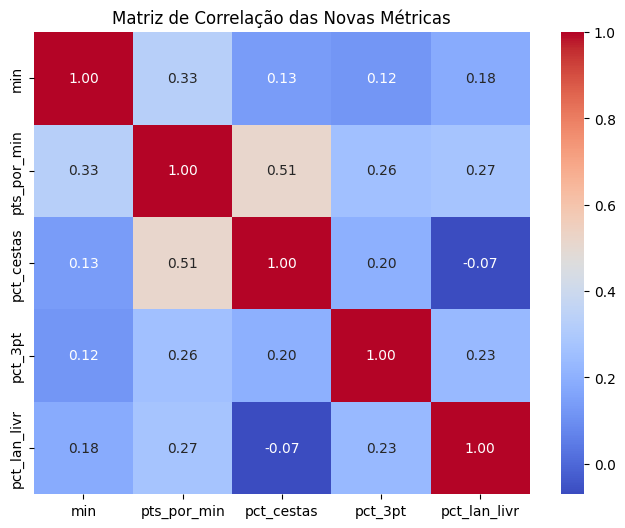

In [9]:
plt.figure(figsize=(8, 6))
# mapa de calor das variáveis numéricas
sns.heatmap(df.iloc[:, 1:].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Novas Métricas')
plt.show()

Exceto pela correlação entre pts_por_min e pct_cestas, a matriz mostra baixas correlações. Como as features não são fortemente correlacionadas, o modelo tende a funcionar melhor.

In [49]:
top_counts = df['liga'].value_counts()
top_5_ligas = top_counts.head(5).index.tolist()
df = df[df['liga'].isin(top_5_ligas)].reset_index(drop=True)
df['liga'].value_counts()

,count
liga,
NBA,301
Chinese-CBA,295
FIBA-Europe-Cup,242
Japanese-BLeague,238
Euroleague,236


Vou pegar as top 5 ligas com mais jogadores para testar os modelos.

## 4. Definição do target, variáveis e divisão dos dados

Utilizando as métricas criadas de porcentagem de acerto, o objetivo é estimar em qual liga o jogador participa com base nesses critérios.

In [11]:
# Tipo de Problema
PROBLEM_TYPE = "Classificação"

#Definição do target
target = "liga"

#Número de colunas que não são target
features = [c for c in df.columns if c not in [target, "timestamp"]]

print("Problem Type:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# Divisão dos dados
X = df[features].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y)

print("Treino:", X_train.shape, "| Teste:", X_test.shape)

Problem Type: Classificação
Target: liga
N features: 5
Treino: (1049, 5) | Teste: (263, 5)



## 5. Tratamento de dados e **Pipeline** de pré-processamento


In [12]:
num_cols = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]
cat_cols = [c for c in X_train.columns if c not in num_cols and c != "timestamp"]


print("Colunas numéricas", num_cols[:5], "...")
print("Colunas categóricas:", cat_cols[:5], "...")

# Como o dataframe não possui colunas categóricas, temos apenas numéricas
num_cols = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]

# 3. Pipeline numérico, susbtituir nulos pela mediana
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols)
])

Colunas numéricas ['min', 'pts_por_min', 'pct_cestas', 'pct_3pt', 'pct_lan_livr'] ...
Colunas categóricas: [] ...



## 6. Baseline e modelos candidatos
Vou utilizar 3 abordagens: **Regressão Logística**, um modelo simples, interpretável e computacionalmente eficiente, **Random Forest**, pela capacidade de capturar relações não lineares e interações entre variáveis, o que é relevante no contexto do desempenho de jogadores de basquete, e **Naive Bayes** pela baixa correlação entre as métricas, como já foi demonstrado.


In [13]:
# === Baselines ===
baseline = Pipeline(steps=[("pre", preprocess),("model", DummyClassifier(strategy="most_frequent", random_state=SEED))])

candidates = {
        "LogisticRegression": Pipeline([("pre", preprocess), ("model", LogisticRegression(max_iter=200, class_weight="balanced" ,random_state=SEED))]),
        "RandomForest": Pipeline([("pre", preprocess), ("model", RandomForestClassifier(class_weight="balanced",random_state=SEED))]),
        "GaussianNB": Pipeline([("pre", preprocess),("model", GaussianNB())])
    }

baseline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['min', 'pts_por_min',
                                                   'pct_cestas', 'pct_3pt',
                                                   'pct_lan_livr'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

Vou testar outra baseline com o modelo KNN.

In [14]:
# === Baselines ===
baseline2 = Pipeline(steps=[
    ("pre", preprocess),
    ("model", KNeighborsClassifier(n_neighbors=7))  #baseline com KNN
])

baseline2

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['min', 'pts_por_min',
                                                   'pct_cestas', 'pct_3pt',
                                                   'pct_lan_livr'])])),
                ('model', KNeighborsClassifier(n_neighbors=7))])


### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Vou treinar um modelo baseline e diferentes modelos candidatos para prever a liga dos jogadores a partir das estatísticas disponíveis.
A avaliação será por meio de acurácia, F1, ROC AUC e tempo de treino.

In [15]:
results = {}

t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()
y_pred = baseline.predict(X_test)
proba = baseline.predict_proba(X_test) if hasattr(baseline, "predict_proba") else None
results["baseline"] = evaluate_classification(y_test, y_pred, proba) #alterei a função porque se trata de um problema de classificação multiclasse


# Candidatos
for name, pipe in candidates.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()
    y_pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
    results[name] = evaluate_classification(y_test, y_pred, proba)
    results[name]["train_time_s"] = round(t1 - t0, 3)

pd.DataFrame(results).T


,accuracy,f1_weighted,roc_auc,train_time_s
baseline,0.228137,0.084757,0.500000,NaN
LogisticRegression,0.494297,0.475424,0.800801,0.031
RandomForest,0.524715,0.513978,0.789941,0.468
GaussianNB,0.490494,0.466412,0.772947,0.013


A comparação inicial mostra que os modelos conseguiram superar bem o baseline, que possui desempenho muito baixo em todas as métricas. Entre os modelos, o RandomForest apresentou a maior acurácia e f1_weighted, com um custo maior de processamento, enquanto a LogisticRegression alcançou o melhor ROC AUC, o que indica boa capacidade de separação entre classes. O GaussianNB teve o pior desempenho entre os 3. Esses resultados sugerem que LogisticRegression e RandomForest são as opções mais promissoras, cada um com vantagens distintas. O GaussianNB pode não ter sido tão eficaz porque apesar da baixa correlação, as as variáveis não são independentes.

In [16]:
results = {}

t0 = time.time()
baseline2.fit(X_train, y_train)
t1 = time.time()
y_pred = baseline2.predict(X_test)
proba = baseline2.predict_proba(X_test) if hasattr(baseline2, "predict_proba") else None
results["baseline_KNN"] = evaluate_classification(y_test, y_pred, proba) #alterei a função porque se trata de um problema de classificação multiclasse


# Candidatos
for name, pipe in candidates.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()
    y_pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
    results[name] = evaluate_classification(y_test, y_pred, proba)
    results[name]["train_time_s"] = round(t1 - t0, 3)

pd.DataFrame(results).T

,accuracy,f1_weighted,roc_auc,train_time_s
baseline_KNN,0.456274,0.459712,0.747622,NaN
LogisticRegression,0.494297,0.475424,0.800801,0.019
RandomForest,0.524715,0.513978,0.789941,0.463
GaussianNB,0.490494,0.466412,0.772947,0.008


O teste com a baseline KNN mostrou um salto considerável em relação ao DummyClassifier. Apesar disso, os modelos otimizados ainda superaram o baseline, mostrando maior consistência e potencial de generalização.


## 7. Validação e Otimização de Hiperparâmetros

A validação cruzada com StratifiedKFold e o ajuste de hiperparâmetros via RandomizedSearchCV permitiram identificar os parâmetros mais adequados para cada modelo e fazer a comparação de seus desempenhos. Para cada modelo, foi definido um conjunto específico de hiperparâmetros a serem explorados, como número de estimadores e profundidade máxima para Random Forest, valor de regularização e solver para Regressão Logística, suavização para GaussianNB e número de vizinhos e pesos para KNN.


In [44]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


parametros = {
    "model__n_estimators": randint(100, 400),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 10)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# criando modelos e grids
modelos = {
    "RandomForest": (
        RandomForestClassifier(random_state=SEED, class_weight="balanced"),
        {
            "model__n_estimators": randint(200, 400),
            "model__max_depth": randint(10, 20),
            "model__min_samples_split": randint(2, 10),
        },
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=500, class_weight="balanced", random_state=SEED),
        {
            "model__C": uniform(0.01, 10),
            "model__solver": ["lbfgs", "saga"],
        },
    ),
    "GaussianNB": (
        GaussianNB(),
        {
            "model__var_smoothing": uniform(1e-10, 1e-8),
        },
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "model__n_neighbors": randint(3, 15),
            "model__weights": ["uniform", "distance"],
        },
    ),
}

# Dicionário para armazenar os resultados
results = {}

#rodar RandomizedSearchCV em cada modelo
for name, (modelo, parametros) in modelos.items():
    #pré-processamento + modelo
    pipe = Pipeline([("pre", preprocess), ("model", modelo)])

    #busca aleatória de hiperparâmetros
    search = RandomizedSearchCV(
        pipe,
        param_distributions=parametros,
        n_iter=30,               #número de combinações
        scoring="f1_weighted",   #usei essa métrica na validação
        n_jobs=-1,
        cv=cv,                   #validação cruzada estratificada
        random_state=SEED,
        verbose=1
    )

    search.fit(X_train, y_train)

    results[name] = {
        "best_params": search.best_params_,
        "best_score": search.best_score_
    }

pd.DataFrame(results).T

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


,best_params,best_score
RandomForest,"{'model__max_depth': 14, 'model__min_samples_s...",0.528393
LogisticRegression,"{'model__C': 3.0561376917337064, 'model__solve...",0.535484
GaussianNB,{'model__var_smoothing': 3.845401188473625e-09},0.500603
KNN,"{'model__n_neighbors': 13, 'model__weights': '...",0.505999


Os resultados mostram que a Logistic Regression alcançou o melhor desempenho geral - sendo o melhor modelo utilizando **C=3.0561376917337064** e **solver="lbfgs"** - seguida de perto pelo RandomForest, cujo melhor modelo tem os parâmetros **model__max_depth = 14**, **model__min_samples_split = 2** e **model__n_estimators': 257**. O KNN também apresentou um bom resultado. Já o GaussianNB teve desempenho inferior, indicando maior limitação em lidar com a complexidade das variáveis disponíveis.


## 8. Avaliação final, análise de erros e limitações
- **Compare** baseline vs melhor modelo.  
- Faça **análise de erros** (ex.: matriz de confusão, casos pior previstos, resíduos).  
- Discuta **limitações**: dados, métricas, viés, generalização.


### 8.1 Comparação baseline vs melhores modelos

In [45]:
# Baseline
baseline_teste_final = Pipeline(steps=[
    ("pre", preprocess),
    ("model", KNeighborsClassifier(n_neighbors=7))  #baseline com KNN
])

# Candidatos
candidatos_final = {
    "LogisticRegression_original": Pipeline([("pre", preprocess), ("model", LogisticRegression(max_iter=200, class_weight="balanced" ,random_state=SEED))]),
    "LogisticRegression_melhor_modelo": Pipeline([("pre", preprocess),("model", LogisticRegression(C=3.0561376917337064,solver="lbfgs"
    ,max_iter=200,class_weight="balanced",random_state=SEED))]),
    "RandomForest_original": Pipeline([("pre", preprocess), ("model", RandomForestClassifier(class_weight="balanced",random_state=SEED))]),
    "RandomForest_melhor_modelo": Pipeline([("pre", preprocess),("model", RandomForestClassifier(max_depth=14,min_samples_split=2,n_estimators=257,class_weight="balanced",random_state=SEED
        ))])
}



In [46]:
results = {}

t0 = time.time()
baseline_teste_final.fit(X_train, y_train)
t1 = time.time()
y_pred = baseline_teste_final.predict(X_test)
proba = baseline_teste_final.predict_proba(X_test) if hasattr(baseline_teste_final, "predict_proba") else None
results["baseline_teste_final"] = evaluate_classification(y_test, y_pred, proba) #alterei a função porque se trata de um problema de classificação multiclasse


# Candidatos
for name, pipe in candidatos_final.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()
    y_pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
    results[name] = evaluate_classification(y_test, y_pred, proba)
    results[name]["train_time_s"] = round(t1 - t0, 3)

pd.DataFrame(results).T

,accuracy,f1_weighted,roc_auc,train_time_s
baseline_teste_final,0.456274,0.459712,0.747622,NaN
LogisticRegression_original,0.494297,0.475424,0.800801,0.019
LogisticRegression_melhor_modelo,0.498099,0.480817,0.801856,0.024
RandomForest_original,0.524715,0.513978,0.789941,0.439
RandomForest_melhor_modelo,0.520913,0.510898,0.795572,1.026


Realizei uma comparação entre os modelos com tuning de melhores parâmetros, porém sem os hiperparâmetros utilizados na questão anterior, e os modelos sem tuning utilizados anteriormente.

É possível perceber que o modelo LogisticRegression com o tuning melhorou em todos os valores em comparação ao modelo inicial, em troca de um maior tempo de treino. Já o RandomForest piorou em acurácia e f1_weighted, mas melhorou o roc_auc.

### 8.2 Análise de erros

Como o modelo do RandomForest teve uma melhora em relação ao original, possui melhor desempenho na classificação probabilística, melhor f1_weighted com hiperparâmetros e tempo de treino melhor do que o RandomForest, o que ajuda com um dataset com mais valores, vou utilizar sua versão de otimização para verificar os resultados na análise de erros final.

                  precision    recall  f1-score   support

     Chinese-CBA       0.40      0.24      0.30        59
      Euroleague       0.40      0.40      0.40        47
 FIBA-Europe-Cup       0.50      0.78      0.61        49
Japanese-BLeague       0.41      0.35      0.38        48
             NBA       0.68      0.72      0.70        60

        accuracy                           0.50       263
       macro avg       0.48      0.50      0.48       263
    weighted avg       0.49      0.50      0.48       263



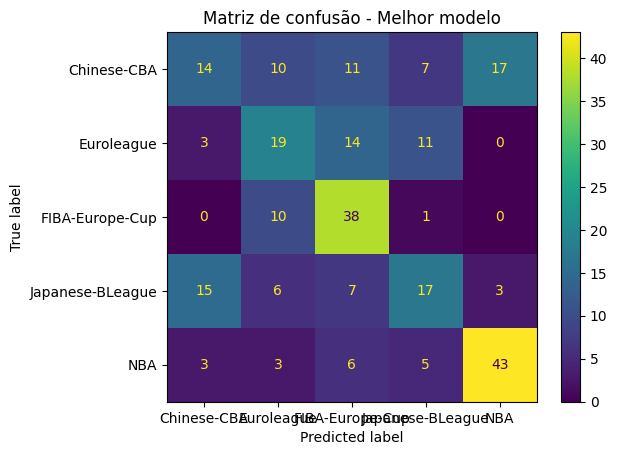

In [47]:
# Exemplo de re-treino no conjunto de treino+validação (se aplicável) e avaliação no teste

melhor_modelo = Pipeline([ ("pre", preprocess), ("model", LogisticRegression( C=3.0561376917337064, solver="lbfgs", max_iter=200, class_weight="balanced", random_state=SEED )) ])

# Treinar no conjunto de treino
melhor_modelo.fit(X_train, y_train)

# Agora sim, pode prever
y_pred = melhor_modelo.predict(X_test)



print(classification_report(y_test, y_pred))
try:
  ConfusionMatrixDisplay.from_estimator(melhor_modelo, X_test, y_test)
  plt.title("Matriz de confusão - Melhor modelo")
  plt.show()
except Exception as e:
  print("Não foi possível plotar a matriz de confusão:", e)

O modelo consegue identificar mais facilmente se os jogadores forem da FIBA - Europe Cup ou da NBA. Se tratam, respectivamente, das ligas com menor e maior média de minutos jogados por jogador.

### 8.3 Limitações

Como se tratam de métricas muito similares, pode ser difícil de diferenciar jogadores apenas por suas características ofensivas de acertos, minutos e pontos. Há vários fatores que podem ser adicionados para que haja uma melhor diferenciação entre as ligas, como peso ou altura, por exemplo.


## 9. Boas práticas e rastreabilidade
*   Para o projeto, as decisões (feature engineering, criação de dataframe com top 5 ligas, candidatos) foram documentadas ao longo do relatório.
*   Cada célula/seção foi projetada para ser executada de forma sequencial, ou seja, a execução de uma seção posteriormente não vai alterar o estado de variáveis ou resultados de outra seção anterior.
*   Foi estabelecido um modelo baseline para servir de referência de desempenho, e os candidatos e suas versões otimizadas foram comparados a esse baseline, para medir as diferenças.
* Para o teste final comparei os 2 melhores modelos com suas versões com melhores parâmetros e o melhor baseline, com o objetivo de oferecer transparência nos resultados finais, e entender o trade-off de cada escolha.







## 10. Conclusões e próximos passos
Os modelos LogisticRegression e RandomForest obtiveram resultados semelhantes, com diferentes parâmetros. Há ainda uma dificuldade em prever a liga com base nas métricas fornecidas, o que sugere a inclusão de diferentes métricas com o objetivo de diferenciar melhor as ligas.

Utilizei apenas uma temporada e poucas ligas, o que permite que esse sistema tenha ainda mais exemplos e possibilidades. A utilização de outros datasets, que possuam informações não inclusas nesse projeto podem ser valiosas para o avanço dessa questão. Além disso, utilizei apenas medidas ofensivas, não compreendendo todo o espectro de estilos de jogo.

A importância desse projeto é de buscar insights mais precisos sobre o desempenho relativo dos atletas, facilitando decisões estratégicas de contratação, avaliação de potencial e preparação de times. As necessidades de cada time devem conduzir as variáveis e processos a serem utilizados.